# Mouse Connectivity SDK
Connectivity data can be accessed on the web. This is useful for browsing and familiarizing yourself with the data, but for more in-depth analyses, it is often better to access data programmatically. The AllenSDK provides Python-based tools to support that approach, and this notebook will introduce you to them.

## Table of Contents
1. [Working in the 3D Common Coordinate Framework](#Working-in-the-3D-Common-Coordinate-Framework)
2. [Working with 3D gridded projection data](#Working-with-3D-gridded-projection-data)
3. [Working-with-the-brain-structure-ontology](#Working-with-the-brain-structure-ontology)
4. [Finding-Connectivity-Data-Sets](#Finding-Connectivity-Data-Sets)
5. [Quantifying-structure-level-projection-strength](#Quantifying-structure-level-projection-strength)

To work through this on your own later you will need to install the `allensdk` python module. You can do this from a command prompt:

`> pip install allensdk`

In [1]:
# imports!
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

In [2]:
%matplotlib inline

## The caching pattern:
We will be using the MouseConnectivityCache class to download and store data. This class requires from us:

* a manifest file path. This path determines where data will be stored. Once you have instantiated your cache once, you can access downloaded data again by instantiating a new cache with the same manifest path. We will be using pre-populated data directories.
* A MouseConnectivityCache is used to copy and cache data from the cell types database. If you create the MouseConnectivityCache instance with no arguments, then data is downloaded from the online repository: 

    mcc = MouseConnectivityCache()

Because we have limited internet bandwidth, the data you need is already provided on AWS. To ensure this local data is used instead of the online repository, create the MouseConnectivityCache instance using the manifest_file argument:

    MouseConnectivityCache(manifest_file='manifest_filename.json')

a resolution for the data volumes that we will be downloading. The possible (isometric) resolutions are 10, 25, 50, and 100-microns, with 25 the default.

As usual, you can use the built in help function to see the complete documentation.

In [3]:
# this file indicates where all the other files we need are laid out
manifest_file = '/data/dynamic-brain-workshop/mouse_connectivity_cache/mouse_connectivity_manifest.json'

# specify your path and isometric resolution
resolution = 25

# instantiate the cache object
# after this step, the manifest file you specified should exist on your filesystem
mcc = MouseConnectivityCache(manifest_file=manifest_file, resolution=resolution)

In [4]:
help(mcc)

Help on MouseConnectivityCache in module allensdk.core.mouse_connectivity_cache object:

class MouseConnectivityCache(allensdk.api.cache.Cache)
 |  Cache class for storing and accessing data related to the adult mouse
 |  Connectivity Atlas.  By default, this class will cache any downloaded
 |  metadata or files in well known locations defined in a manifest file.
 |  This behavior can be disabled.
 |  
 |  Attributes
 |  ----------
 |  
 |  resolution: int
 |      Resolution of grid data to be downloaded when accessing projection volume,
 |      the annotation volume, and the annotation volume.  Must be one of (10, 25,
 |      50, 100).  Default is 25.
 |  
 |  api: MouseConnectivityApi instance
 |      Used internally to make API queries.
 |  
 |  Parameters
 |  ----------
 |  
 |  resolution: int
 |      Resolution of grid data to be downloaded when accessing projection volume,
 |      the annotation volume, and the annotation volume.  Must be one of (10, 25,
 |      50, 100).  Defau

# Working in the 3D Common Coordinate Framework

The Allen Institute has generated an average template volume from 1675 mouse brain image stacks and each of our connectivity datasets is registered to this average template. This allows us to work in a shared 3d space, which we call the Common Coordinate Framework (CCF)

You can view the average template volume using your MouseConnectivityCache:

(528, 320, 456)


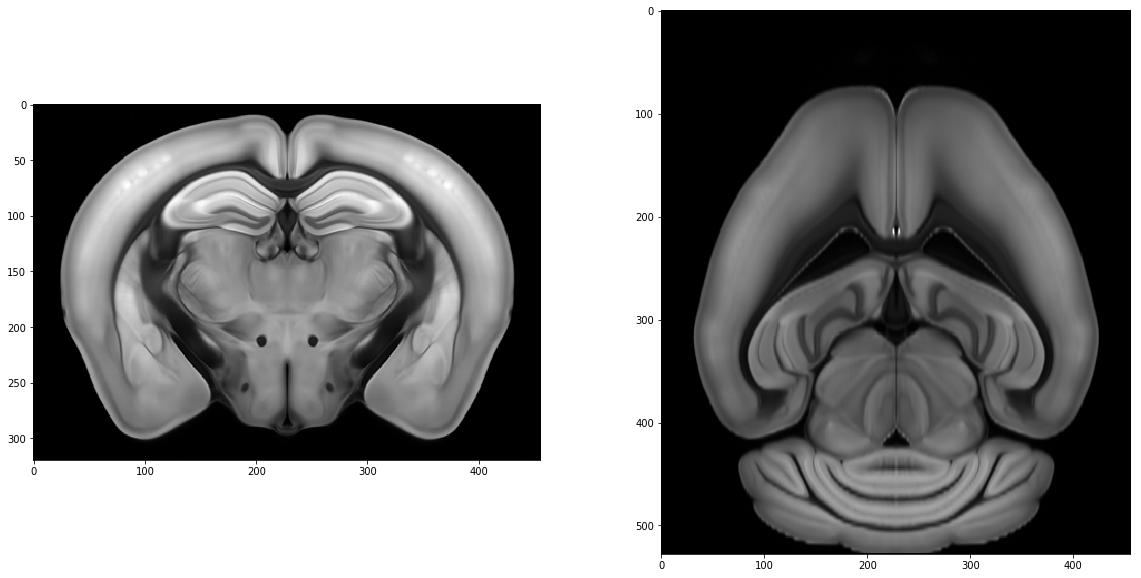

In [5]:
# load up the average template
template, header = mcc.get_template_volume()

# recall that this cache is at 25 micron isometric resolution. how big is the image?
print(template.shape)

# let's see what it looks like
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].imshow(template[280, :, :], cmap=plt.cm.gray) # coronal
axs[1].imshow(template[:, 100, :], cmap=plt.cm.gray) # horizontal
plt.show()

## The annotation volume
Each (brain) voxel in the CCF is associated with a structure in the structure tree. This mapping is recorded in the annotation volume, which occupies the same space as the average template. The value of each voxel in the annotation volume is the id of the most specific structure occupying that point in space.

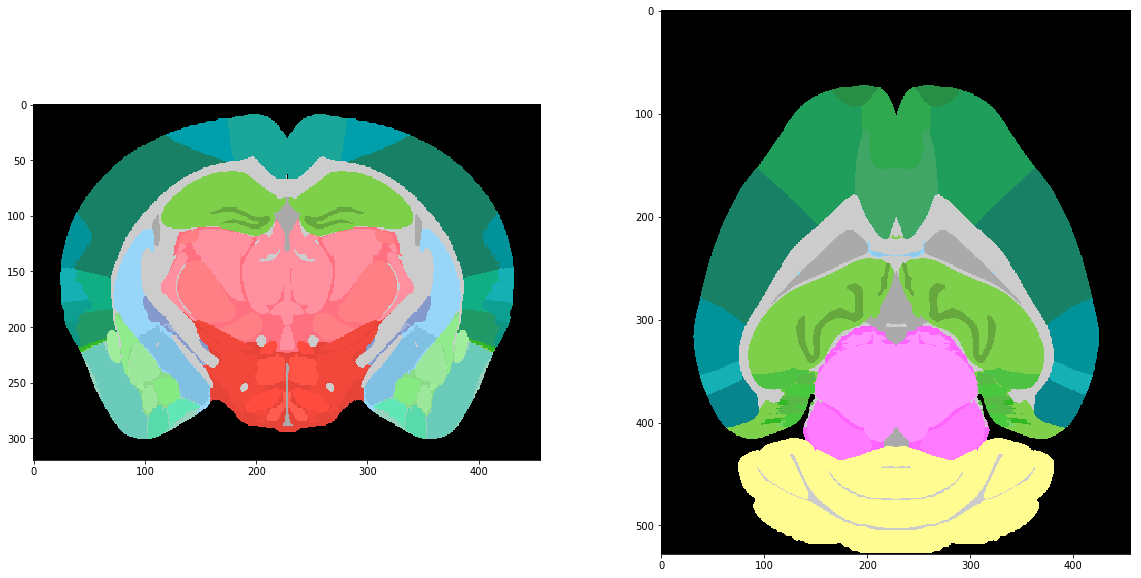

In [6]:
# you can obtain a reference space object from your mouse connectivity cache
# this object handles tasks that require both a structure tree and an annotation volume
reference_space =  mcc.get_reference_space()

# One such task is to apply our predefined structure colors to 
# a slice from the annotation volume
fig, axs = plt.subplots(1, 2, figsize=(20,10))

# coronal section
slice_image = reference_space.get_slice_image(0, 7000) # this method wants an axis and a position in microns
axs[0].imshow(slice_image, interpolation='none')

# horizontal section
slice_image = reference_space.get_slice_image(1, 2500) 
axs[1].imshow(slice_image, interpolation='none')

plt.show()

## Structure masks
The annotation volume and structure tree contain a lot of information in a compact form. It can be simpler to work with more explicit representations of individual structures. We often use binary indicator masks for specific structures. These are:

* volumes in the common coordinate framework
* 1 where the annotation is labeled with a structure or its descendants, otherwise 0

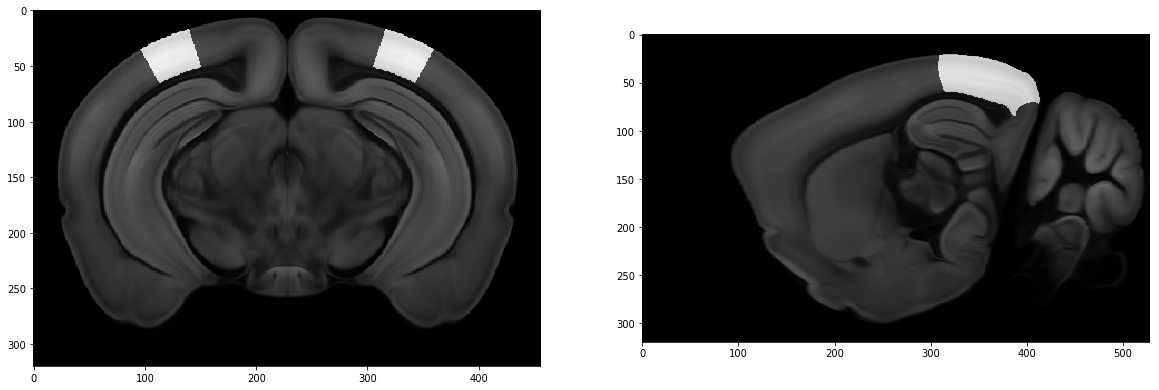

In [7]:
# view a structure mask for primary visual cortex (VISp)
visp_mask, _ = mcc.get_structure_mask(385)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# coronal
axs[0].imshow(visp_mask[325, :, :], interpolation='none', cmap=plt.cm.gray) 
axs[0].imshow(template[325, :, :], interpolation='none', cmap=plt.cm.gray, alpha=0.4)

# saggital
axs[1].imshow(visp_mask[:, :, 125].T, interpolation='none', cmap=plt.cm.gray)
axs[1].imshow(template[:, :, 125].T, interpolation='none', cmap=plt.cm.gray, alpha=0.4)

plt.show()

In [8]:
# we can now easily locate VISp-labeled voxels in space:
print(np.where(visp_mask))

# how many voxels are there?  how big are they?
num_vox = visp_mask.sum()
print("number of voxels: %d" % num_vox)

vol_vox = (resolution * 1e-3) ** 3
print("volume of a voxel: %f mm3" % vol_vox)
print("volume of brain area: %f mm3" % (num_vox * vol_vox))

(array([307, 307, 307, ..., 414, 414, 414]), array([23, 23, 24, ..., 78, 78, 78]), array([121, 335, 119, ..., 338, 339, 340]))
number of voxels: 455143
volume of a voxel: 0.000016 mm3
volume of brain area: 7.111609 mm3


# Working with 3D gridded projection data
Since each connectivity experiment is registered to the CCF, we can load connectivity data in the same way as we do the average template or annotation volume.

Here we will load an experiment's projection density volume. These data:

* are floats in [0, 1]
* represent the fraction of each voxel that is occupied by signal (as detected in the segmentation stage)
* are independent of the injection site (so it makes sense to discuss "projection in the injection site")

In [9]:
# get the projection density for one experiment
prdens, _ = mcc.get_projection_density(159550125)

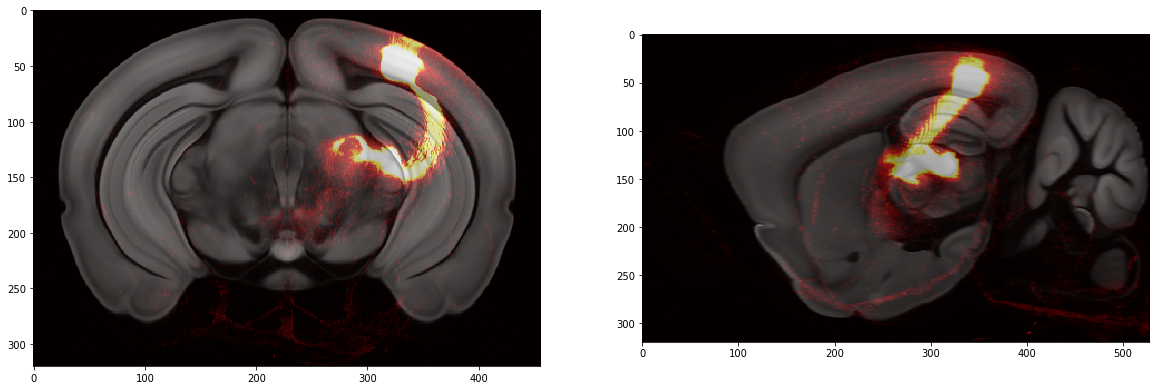

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].imshow(np.amax(prdens, axis=0), cmap='hot')
axs[0].imshow(template[335,:,:], cmap='gray', alpha=0.5)
axs[1].imshow(np.amax(prdens, axis=2).T, cmap='hot')
axs[1].imshow(template[:,:,320].T, cmap='gray', alpha=0.5)
plt.show()

Another useful data volume is the injection fraction. This shows the fraction of each voxel that lies within this experiment's manually annotated injection site

In [11]:
ijfr, _ = mcc.get_injection_fraction(159550125)

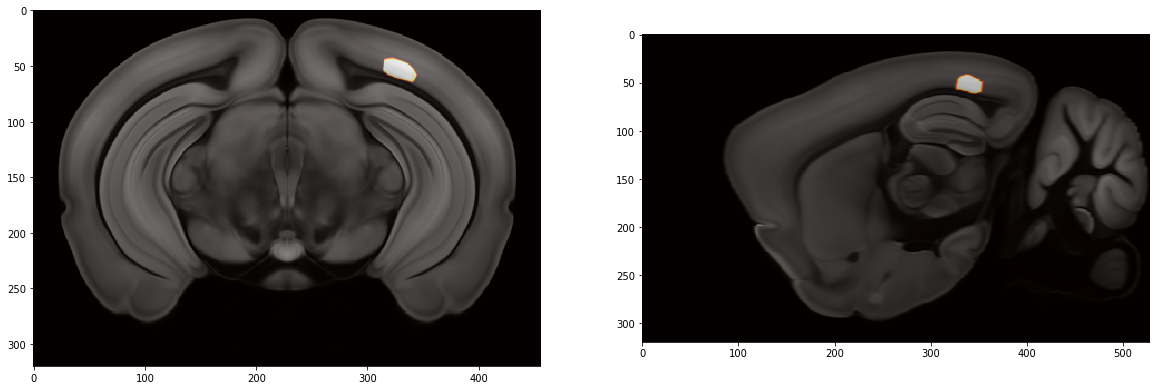

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(ijfr[335,:,:], cmap='hot')
axs[0].imshow(template[335,:,:], cmap='gray', alpha=0.5)

axs[1].imshow(ijfr[:,:,320].T, cmap='hot')
axs[1].imshow(template[:,:,320].T, cmap='gray', alpha=0.5)

plt.show()

# Working with the brain structure ontology

Anatomists at the Allen Institute have divided the adult mouse brain into ~1300 distinct structures. These are arranged in a tree, where coarsely specified structures (e.g. 'Isocortex') are near the root and finely specified structures (e.g "Primary visual area, layer 4") make up the leaves. Here is a handy visualization of the tree (and atlas!).

You can download and access the structure tree by calling get_structure_tree on your MouseConnectivityCache instance. The methods in structure_tree are useful for navigating the atlas and connectivity data.

In [13]:
# get the structure tree
# this step should produce a file called 'structures.json' in the same directory as your manifest file
structure_tree = mcc.get_structure_tree()

# view the structure record for primary visual cortex
visp = structure_tree.get_structures_by_name(['Primary visual area'])

# the data structure returned by this method is a list of dictionaries:
visp

[{'acronym': u'VISp',
  'graph_id': 1,
  'graph_order': 185,
  'id': 385,
  'name': u'Primary visual area',
  'rgb_triplet': [8, 133, 140],
  'structure_id_path': [997, 8, 567, 688, 695, 315, 669, 385],
  'structure_set_ids': [396673091,
   112905828,
   12,
   184527634,
   514166994,
   112905813,
   114512891,
   114512892,
   167587189]}]

# Finding Connectivity Data Sets

Which experiments have injections into your structure? On connectivity.brain-map.org you can do a `source search` to list experiments by the region into which viral tracer was injected. It is possible to do a similar search programmatically using the SDK.

In [14]:
# get a table of injection experiments. This is a list of dictionaries.
experiments = mcc.get_experiments(injection_structure_ids=[385]) # insert your structure id here

# look at one of them
experiments[150]

{u'gender': u'M',
 u'id': 482640524,
 u'injection-coordinates': [8770, 830, 4000],
 u'injection-structures': [{u'abbreviation': u'VISp',
   u'color': u'08858C',
   u'id': 385,
   u'name': u'Primary visual area'},
  {u'abbreviation': u'VISpm',
   u'color': u'08858C',
   u'id': 533,
   u'name': u'posteromedial visual area'},
  {u'abbreviation': u'RSPd',
   u'color': u'1AA698',
   u'id': 879,
   u'name': u'Retrosplenial area, dorsal part'},
  {u'abbreviation': u'RSPagl',
   u'color': u'1AA698',
   u'id': 894,
   u'name': u'Retrosplenial area, lateral agranular part'}],
 u'product-id': 36,
 u'strain': u'',
 u'structure-abbrev': u'VISp',
 u'structure-color': u'08858C',
 u'structure-id': 385,
 u'structure-name': u'Primary visual area',
 u'transgenic-line': u'Scnn1a-Tg3-Cre'}

In [15]:
# DataFrames are nice
dat = pd.DataFrame(experiments)
dat.head()

,gender,id,injection-coordinates,injection-structures,product-id,strain,structure-abbrev,structure-color,structure-id,structure-name,transgenic-line
0,M,180296424,"[9570, 1750, 8510]","[{u'abbreviation': u'VISp', u'color': u'08858C...",5,C57BL/6J,VISp,08858C,385,Primary visual area,
1,M,512315551,"[9190, 1820, 1750]","[{u'abbreviation': u'VISp', u'color': u'08858C...",36,,VISp,08858C,385,Primary visual area,Emx1-IRES-Cre
2,M,309004492,"[9200, 1720, 8330]","[{u'abbreviation': u'VISp', u'color': u'08858C...",5,C57BL/6J,VISp,08858C,385,Primary visual area,
3,M,113887162,"[8300, 1170, 7870]","[{u'abbreviation': u'VISp', u'color': u'08858C...",5,C57BL/6J,VISp,08858C,385,Primary visual area,
4,M,307558646,"[8780, 1390, 7890]","[{u'abbreviation': u'VISp', u'color': u'08858C...",5,C57BL/6J,VISp,08858C,385,Primary visual area,


# Quantifying structure-level projection strength
Which structures recieve the most projections from your favorite structure?

## A nonoverlapping set of structures
A question like "which structures recieve the most projections from a source structure" doesn't make much sense across the whole tree - some structures contain others and will therefore end up higher on the list.

We've created a nonoverlapping list of 293 biologically relevant structures, which we call the "summary structures." These are the same structures you see on the website experiment detail page. You can download a list of summary structures using the ontologies api:

In [16]:
oapi = OntologiesApi()
summary_structures = oapi.get_structures(structure_set_names="'Mouse Connectivity - Summary'")
summary_structure_ids = [item['id'] for item in summary_structures]


In order to answer this question you will need a set of structurewise projection summaries. One way to obtain these summary values would be to apply masks to the projection density across a wide range of structures and experiments. This would be quite time-consuming, so we have precomputed such values for all experiments and structures. We call these summary values "unionizes" because they are the union of projection densities and structures.

Unionizes are returned as Pandas DataFrames. Pandas makes it easy to:

* Find the regions that receive the strongest projections using pandas.DataFrame.sort_values
* Find the mean projection strength by structure across experiments using pandas.DataFrame.groupby combined with pandas.DataFrame.mean
* Graph the data

In [17]:
# First let's find the targets for a single experiment:
sample_experiment = 478257959 

unionizes = mcc.get_structure_unionizes(experiment_ids=[sample_experiment],
                                        # Since we are looking at projection targets, we set "is_injection" to False
                                       is_injection = False,
                                        # Look at the summary structure level
                                        structure_ids = summary_structure_ids,
                                       # both hemispheres
                                       hemisphere_ids = [3])

print(len(unionizes))

293


In [18]:
unionizes.head()

,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,experiment_id,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume
0,3,546015928,False,0.128911,8140,2730,750,0.001209,0.000035,0.009613,278.174,0.000082,478257959,1002,5.250520e+11,1.930580e+09,18558000.0,66713.5,2.364970
1,3,546015413,False,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000,0.000000,478257959,177,1.386890e+09,1.959120e+07,0.0,0.0,0.023999
2,3,546015841,False,0.465926,9320,1600,3890,0.014543,0.000202,0.101707,503.287,0.000983,478257959,886,9.698010e+11,3.969800e+09,403757000.0,802241.0,4.863000
3,3,546015966,False,0.543256,4300,4450,1650,0.005570,0.000200,0.061405,306.723,0.000376,478257959,1057,4.393320e+11,1.534650e+09,94235200.0,307233.0,1.879950
4,3,546015867,False,0.457239,10600,3300,4360,0.008001,0.000125,0.042445,338.647,0.000541,478257959,920,9.131960e+11,3.521130e+09,149456000.0,441332.0,4.313380


Each row in this table is a different unionize record. Some of the columns tell you what spatial domain the unionize record summarizes over:
* structure_id : Which structure does the unionize summarize over?
* hemisphere_id* : Does the unionize summarize over the left hemisphere, the right, or both?
* is_injection : Does the unionize correspond the the part of this structure which is within the injection site?

The "experiment_id" column identifies the experiment from which this unionize's data was drawn. This is not to be confused (!) with the "id" column, which is a unique identifier for this specific unionize record.

All of the other fields are summaries of data. You can find a reference for these here.

* the hemisphere ids are: 1 => left, 2 => right, 3 => both

## Mapping ids to names
We can identify a structure by:

* Its id
* Its name
* Its acronym

Frequently, we want to switch between these. For instance, unionizes return results for structures by their id, but we want to know the names of the structures to be able to interpret the data. The structure tree can be used to generate a map from ids to names:

In [19]:
name_map = structure_tree.get_name_map()
name_map[385]

u'Primary visual area'

In [20]:
# The structure tree also has a built-in map for going from acronyms to ids:
acronym_to_id_map = structure_tree.get_id_acronym_map()
acronym_to_id_map['VISp']

385

In [21]:
# We can use the name_map method from structure_tree to add a "structure names" column to our unionizes dataframe

names = [name_map[strid] for strid in unionizes['structure_id']]
unionizes['structure_name'] = names

In [22]:
unionizes.head()

,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,experiment_id,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume,structure_name
0,3,546015928,False,0.128911,8140,2730,750,0.001209,0.000035,0.009613,278.174,0.000082,478257959,1002,5.250520e+11,1.930580e+09,18558000.0,66713.5,2.364970,Primary auditory area
1,3,546015413,False,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000,0.000000,478257959,177,1.386890e+09,1.959120e+07,0.0,0.0,0.023999,Nucleus of Roller
2,3,546015841,False,0.465926,9320,1600,3890,0.014543,0.000202,0.101707,503.287,0.000983,478257959,886,9.698010e+11,3.969800e+09,403757000.0,802241.0,4.863000,"Retrosplenial area, ventral part"
3,3,546015966,False,0.543256,4300,4450,1650,0.005570,0.000200,0.061405,306.723,0.000376,478257959,1057,4.393320e+11,1.534650e+09,94235200.0,307233.0,1.879950,Gustatory areas
4,3,546015867,False,0.457239,10600,3300,4360,0.008001,0.000125,0.042445,338.647,0.000541,478257959,920,9.131960e+11,3.521130e+09,149456000.0,441332.0,4.313380,Central lobule


In [23]:
unionizes.sort_values(by = 'projection_density', ascending = False, inplace = True)

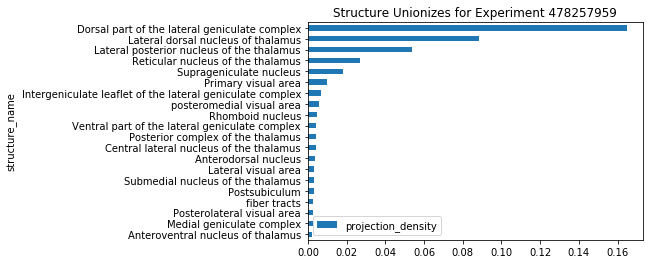

In [24]:
# Plot the 20 structures with the highest projection density in this experiment
unionizes[:20].plot('structure_name', 'projection_density', kind='barh')
plt.gca().invert_yaxis()
plt.title('Structure Unionizes for Experiment %s'%sample_experiment)
plt.show()

## Working with data from many experiments
Instead of looking at a single experiment, you can also obtain all of the unionizes for a given set of experiments. For example, we can find all the projection unionizes for all injections into VISp in wild type mice.

In [25]:
experiment_set = [exp['id'] for exp in experiments if exp['transgenic-line'] == '']
print('number of injections in wild type mice: ', len(experiment_set))
unionizes_set = mcc.get_structure_unionizes(experiment_set,
                                               is_injection = False,
                                                # Look at the summary structure level
                                                structure_ids = summary_structure_ids,
                                               # both hemispheres
                                               hemisphere_ids = [3])
print('length of unionize results: ', len(unionizes_set))

('number of injections in wild type mice: ', 31)
('length of unionize results: ', 9083)


In [26]:
# We can combine groupby and mean to find the average projection density across experiments for each summary structure
unionizes_set_mean = (
    unionizes_set.groupby('structure_id', as_index = False)['projection_density'].mean()
                        )
print(unionizes_set_mean.shape)

(293, 2)


In [27]:
# Again, add a column with summary structure acronyms so we can interpret the unionizes more easily

names = [name_map[strid] for strid in unionizes_set_mean['structure_id']]
unionizes_set_mean['structure_name'] = names

In [28]:
unionizes_set_mean.sort_values(by = 'projection_density', ascending = False, inplace = True)

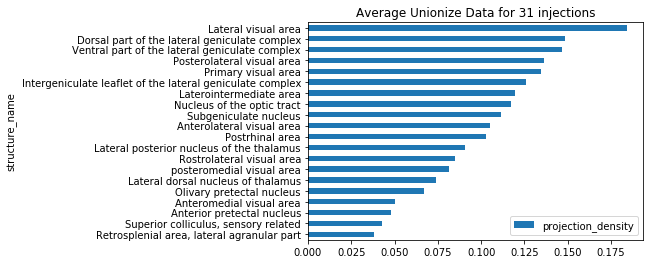

In [29]:
# Plot the 20 structures with the highest average projection density across all wild type VISp injections
unionizes_set_mean[:20].plot('structure_name', 'projection_density', kind='barh')
plt.gca().invert_yaxis()
plt.title('Average Unionize Data for %i injections'%len(experiment_set))
plt.show()